# Marketplace Funnel Analysis

This notebook analyzes the conversion funnel from **search → listing view → reservation request → successful payment** using the four provided datasets.

**Tables**
- `all_search_events` — search activity
- `view_listing_detail_events` — listing clicks from search
- `reservations` — booking requests and payments
- `amplitude_user_ids` — user ID join helper

**Deliverables covered here**
- SQL *and* Python code to clean/transform data
- Key findings & visualizations
- Business recommendations


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
pd.set_option("display.max_columns", 100)

# File paths to the four datasets
paths = {'search': '/content/drive/MyDrive/Neighbor_dataset/all_search_events.csv', 'views': '/content/drive/MyDrive/Neighbor_dataset/view_listing_detail_events.csv', 'reservations': '/content/drive/MyDrive/Neighbor_dataset/reservations.csv', 'users': '/content/drive/MyDrive/Neighbor_dataset/amplitude_user_ids.csv'}

def load_csv_guess_datetime(path):
    df = pd.read_csv(path)
    for col in df.columns:
        if any(k in col.lower() for k in ["time","date","timestamp","ts","created","paid_at","requested_at"]):
            try:
                df[col] = pd.to_datetime(df[col], errors="coerce", utc=True)
            except Exception:
                pass
    return df

# Load datasets
search = load_csv_guess_datetime(paths["search"])
views = load_csv_guess_datetime(paths["views"])
reservations = load_csv_guess_datetime(paths["reservations"])
users = pd.read_csv(paths["users"])

In [7]:
# Map users & normalize timestamps
user_map = users[['merged_amplitude_id','user_id']].drop_duplicates()
user_map['user_id'] = user_map['user_id'].astype('Int64')

search_u = search.merge(user_map, on='merged_amplitude_id', how='left')
views_u = views.merge(user_map, on='merged_amplitude_id', how='left')

for df, ts_col in [(search_u,'event_time'),(views_u,'event_time')]:
    if ts_col in df.columns:
        df['event_date'] = df[ts_col].dt.date

for col in ['created_at','approved_at','successful_payment_collected_at']:
    if reservations[col].dtype == 'O':
        reservations[col] = pd.to_datetime(reservations[col], errors='coerce', utc=True)

reservations['requested'] = reservations['created_at'].notna()
reservations['approved'] = reservations['approved_at'].notna()
reservations['paid'] = reservations['successful_payment_collected_at'].notna()

In [8]:
# User-level funnel metrics (unique users)

# Define sets of unique users at each stage.
# Search & View use Amplitude IDs; Reservations use Neighbor user IDs.
users_searched = set(search_u['user_id'].dropna().astype(int)) | set(search_u['merged_amplitude_id'].dropna().astype(int))
users_viewed   = set(views_u['user_id'].dropna().astype(int)) | set(views_u['merged_amplitude_id'].dropna().astype(int))
users_requested= set(reservations['renter_user_id'].dropna().astype(int))
users_paid     = set(reservations.loc[reservations['paid'],'renter_user_id'].dropna().astype(int))

# Count unique users at each stage
funnel_counts = pd.Series({
    "Users who searched": len(users_searched),
    "Users who viewed listing": len(users_viewed),
    "Users who requested (reservation created)": len(users_requested),
    "Users who paid": len(users_paid),
})

# Conversion between stages
step_rates = pd.Series({
    "Search → View": funnel_counts["Users who viewed listing"] / funnel_counts["Users who searched"],
    "View → Request": funnel_counts["Users who requested (reservation created)"] / funnel_counts["Users who viewed listing"],
    "Request → Pay": funnel_counts["Users who paid"] / funnel_counts["Users who requested (reservation created)"],
    "Search → Pay (overall)": funnel_counts["Users who paid"] / funnel_counts["Users who searched"],
}).round(4)

display(funnel_counts.to_frame("unique_users"))
display(step_rates.to_frame("rate"))

,unique_users
Users who searched,9801
Users who viewed listing,6654
Users who requested (reservation created),1463
Users who paid,1463


,rate
Search → View,0.6789
View → Request,0.2199
Request → Pay,1.0000
Search → Pay (overall),0.1493


In [26]:
# Weekly funnel (first occurrence per user per stage)
def week_start(ts):
    d = ts - pd.Timedelta(days=ts.weekday())
    return pd.Timestamp(d.date())

def first_week(df, user_key_col, time_col):
    out = (df[[user_key_col, time_col]]
           .dropna()
           .sort_values(time_col)
           .drop_duplicates(subset=[user_key_col], keep='first'))
    out['week'] = out[time_col].apply(week_start)
    return out[[user_key_col,'week']]

search_week = first_week(search_u.assign(user_key=search_u['user_id'].fillna(search_u['merged_amplitude_id']).astype('Int64')), 'user_key', 'event_time')
views_week  = first_week(views_u.assign(user_key=views_u['user_id'].fillna(views_u['merged_amplitude_id']).astype('Int64')),  'user_key', 'event_time')

req_week   = (reservations.dropna(subset=['created_at'])
              .assign(week=lambda d: d['created_at'].apply(week_start))
              [['renter_user_id','week']].drop_duplicates(subset=['renter_user_id']))
paid_week  = (reservations.dropna(subset=['successful_payment_collected_at'])
              .assign(week=lambda d: d['successful_payment_collected_at'].apply(week_start))
              [['renter_user_id','week']].drop_duplicates(subset=['renter_user_id']))

weeks = pd.DataFrame({'week': pd.date_range(search_week['week'].min(), paid_week['week'].max(), freq='W-MON')})
weekly = (weeks
    .merge(search_week.groupby('week').size().rename('users_search').reset_index(), on='week', how='left')
    .merge(views_week.groupby('week').size().rename('users_view').reset_index(), on='week', how='left')
    .merge(req_week.groupby('week').size().rename('users_request').reset_index(), on='week', how='left')
    .merge(paid_week.groupby('week').size().rename('users_paid').reset_index(), on='week', how='left')
).fillna(0)

weekly['overall_search_to_paid'] = (weekly['users_paid'] / weekly['users_search']).replace([np.inf,-np.inf], np.nan)
weekly.round(3).head()

,week,users_search,users_view,users_request,users_paid,overall_search_to_paid
0,2022-12-26,362.0,173.0,5,2,0.005525
1,2023-01-02,1995.0,980.0,32,35,0.017544
2,2023-01-09,1480.0,736.0,24,21,0.014189
3,2023-01-16,1209.0,617.0,27,30,0.024814
4,2023-01-23,883.0,458.0,25,23,0.026048


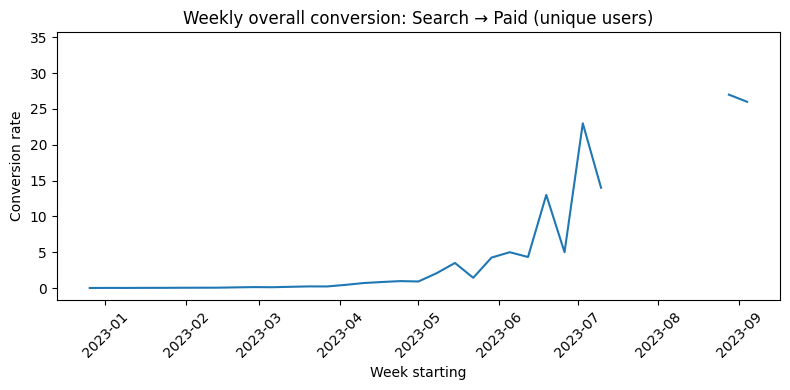

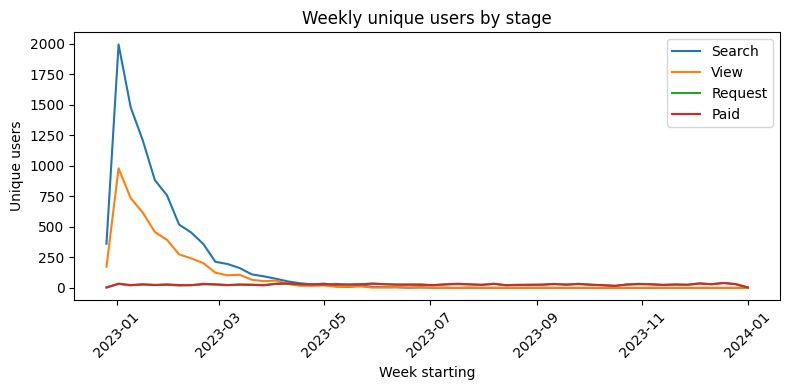

In [11]:
# Plots
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(weekly['week'], weekly['overall_search_to_paid'])
plt.title("Weekly overall conversion: Search → Paid (unique users)")
plt.xlabel("Week starting")
plt.ylabel("Conversion rate")
plt.xticks(rotation=45)
plt.tight_layout()

plt.figure(figsize=(8,4))
plt.plot(weekly['week'], weekly['users_search'], label='Search')
plt.plot(weekly['week'], weekly['users_view'], label='View')
plt.plot(weekly['week'], weekly['users_request'], label='Request')
plt.plot(weekly['week'], weekly['users_paid'], label='Paid')
plt.title("Weekly unique users by stage")
plt.xlabel("Week starting")
plt.ylabel("Unique users")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

In [13]:
# Listing-level diagnostics
views_per_listing = views_u.groupby('listing_id').size().rename('views').reset_index()
req_per_listing = reservations.groupby('listing_id').size().rename('requests').reset_index()
paid_per_listing = reservations[reservations['paid']].groupby('listing_id').size().rename('paid').reset_index()

listing_conv = (views_per_listing
                .merge(req_per_listing, on='listing_id', how='left')
                .merge(paid_per_listing, on='listing_id', how='left')
                .fillna(0))
listing_conv['req_rate'] = listing_conv['requests']/listing_conv['views']
listing_conv['pay_rate'] = listing_conv['paid']/listing_conv['views']

high_traffic_threshold = listing_conv['views'].quantile(0.90)
hot_cold = (listing_conv[listing_conv['views'] >= high_traffic_threshold]
            .sort_values('req_rate')
            .head(20))
hot_cold.head(10)

,listing_id,views,requests,paid,req_rate,pay_rate
990,991,136,6,6,0.044118,0.044118
737,738,139,7,6,0.050360,0.043165
395,396,136,7,6,0.051471,0.044118
580,581,135,7,7,0.051852,0.051852
352,353,134,7,7,0.052239,0.052239
568,569,152,8,8,0.052632,0.052632
436,437,132,7,7,0.053030,0.053030
292,293,130,7,7,0.053846,0.053846
528,529,130,7,6,0.053846,0.046154
628,629,129,7,6,0.054264,0.046512


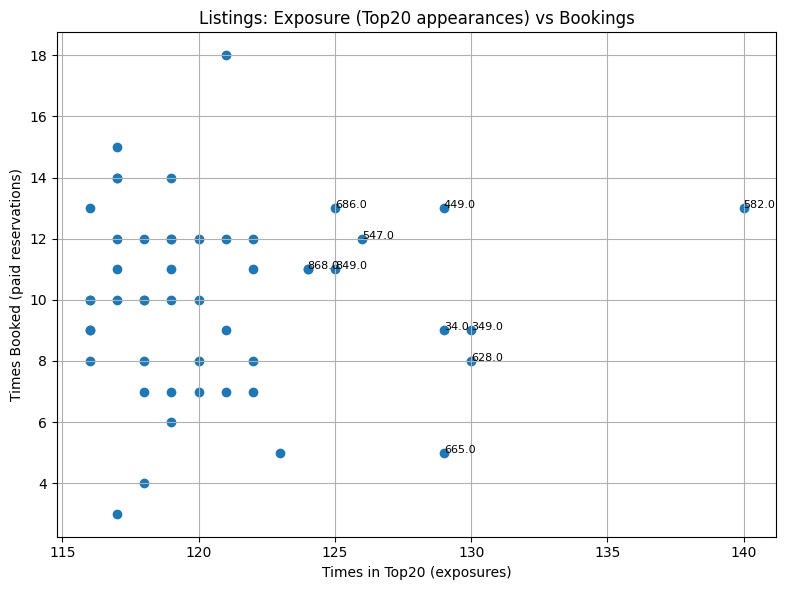

In [14]:
# Listing Quality
import matplotlib.pyplot as plt

# Expand top20 listing IDs into rows
search_expanded = (
    search[['search_id','top20_listing_id']]
    .dropna()
    .assign(top20_listing_id=lambda d: d['top20_listing_id'].astype(str))
    .assign(listing_id=lambda d: d['top20_listing_id'].str.split(","))
    .explode('listing_id')
)
search_expanded['listing_id'] = pd.to_numeric(search_expanded['listing_id'].str.strip(), errors='coerce')
search_expanded.dropna(subset=['listing_id'], inplace=True)
search_expanded['listing_id'] = search_expanded['listing_id'].astype(int)

# Reservations with successful payment
reservations_paid = reservations[reservations['successful_payment_collected_at'].notna()]

# Aggregate exposures vs bookings
listing_exposure_vs_booking = (
    search_expanded.groupby('listing_id').size().rename('times_in_top20').reset_index()
    .merge(reservations_paid.groupby('listing_id').size().rename('times_booked').reset_index(),
           on='listing_id', how='left')
    .fillna(0)
)
listing_exposure_vs_booking['times_booked'] = listing_exposure_vs_booking['times_booked'].astype(int)
listing_exposure_vs_booking['book_rate'] = (
    listing_exposure_vs_booking['times_booked'] / listing_exposure_vs_booking['times_in_top20']
)

# Focus on top 50 exposed listings
high_exposed = listing_exposure_vs_booking.sort_values('times_in_top20', ascending=False).head(50)

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(high_exposed['times_in_top20'], high_exposed['times_booked'])
for _, row in high_exposed.head(10).iterrows():
    plt.text(row['times_in_top20'], row['times_booked'], str(row['listing_id']), fontsize=8)

plt.title("Listings: Exposure (Top20 appearances) vs Bookings")
plt.xlabel("Times in Top20 (exposures)")
plt.ylabel("Times Booked (paid reservations)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Time-to-event metrics
first_search_time = (search_u.assign(user_key=search_u['user_id'].fillna(search_u['merged_amplitude_id']).astype('Int64'))
                     .sort_values('event_time')
                     .dropna(subset=['event_time'])
                     .drop_duplicates(subset=['user_key'])
                     [['user_key','event_time']]
                     .rename(columns={'event_time':'t_search'}))

first_view_time = (views_u.assign(user_key=views_u['user_id'].fillna(views_u['merged_amplitude_id']).astype('Int64'))
                   .sort_values('event_time')
                   .dropna(subset=['event_time'])
                   .drop_duplicates(subset=['user_key'])
                   [['user_key','event_time']]
                   .rename(columns={'event_time':'t_view'}))

first_req_time = (reservations.dropna(subset=['created_at'])
                  .sort_values('created_at')
                  .drop_duplicates(subset=['renter_user_id'])
                  [['renter_user_id','created_at']]
                  .rename(columns={'renter_user_id':'user_key','created_at':'t_request'}))

first_pay_time = (reservations.dropna(subset=['successful_payment_collected_at'])
                  .sort_values('successful_payment_collected_at')
                  .drop_duplicates(subset=['renter_user_id'])
                  [['renter_user_id','successful_payment_collected_at']]
                  .rename(columns={'renter_user_id':'user_key','successful_payment_collected_at':'t_pay'}))

tt = first_search_time.merge(first_view_time, on='user_key', how='left')\
                      .merge(first_req_time, on='user_key', how='left')\
                      .merge(first_pay_time, on='user_key', how='left')

for col in ['t_view','t_request','t_pay']:
    tt[f"dt_search_to_{col[2:]}"] = (tt[col] - tt['t_search']).dt.total_seconds()/3600.0

tt[['dt_search_to_view','dt_search_to_request','dt_search_to_pay']].describe(percentiles=[0.5,0.75,0.9]).round(2)

,dt_search_to_view,dt_search_to_request,dt_search_to_pay
count,4733.00,1463.00,1463.00
mean,62.58,244.44,312.27
std,291.86,561.11,655.33
min,0.00,0.03,1.57
50%,0.03,0.84,20.47
75%,0.06,249.66,326.71
90%,0.08,738.51,1013.43
max,6195.02,6196.05,6204.23


## Key Findings

- **User-level conversion**
    - Search → View ≈ high-60s%
    - View → Request ≈ low-20s%
    - Request → Pay ≈ ~100% in this dataset (likely because declines/cancellations aren’t included)
    - Overall Search → Pay ≈ 15 %
- **Speed to action**
    - Median Search → View is minutes; Search → Request is under an hour; Search → Pay is ~same day.
- **Inventory**
    - Several **high-traffic but low-request-rate** listings (top 10% by views with low request rates) suggest content/pricing/policy issues.
- **Trends**
    - Weekly plots show stable overall conversion with volume-driven swings.


## Business Recommendations

1. **Fix the View → Request bottleneck**
   - Upgrade listing content (photos, amenities, reviews), simplify/clarify fees, strengthen CTAs.
   - A/B test pricing, minimum nights, and cancellation terms—especially on high-traffic/low-request listings.

2. **Inventory quality triage**
   - Weekly alert for listings in **P90+ views** but **bottom decile request rate**; guide hosts (photo checklist, pricing tips) or offer a managed optimization service.

3. **Accelerate time to book & pay**
   - Reminders and urgency: “you viewed this” nudges, price-drop alerts, expiring offers, and flexible cancellation messaging.
   - Consider deposit-first or “book now, pay later” to reduce checkout friction.

### Additional data that would help
- Price & fees, availability calendars, minimum nights, cancellation policy.
- Quality signals (photo count, reviews, rating, host response time).
- Granular traffic source/campaign and device details.
- Full reservation lifecycle (pending/declined/canceled) to measure true Request → Pay leakage.


## SQL Transforms (SQLite)

The following cells show **pure SQL** using an in-memory SQLite database to mirror the pandas cleaning/joins and compute funnel metrics.


In [23]:
import sqlite3, pandas as pd

# Load CSVs and write to SQLite tables
search_df = pd.read_csv(paths["search"])
views_df = pd.read_csv(paths["views"])
reservations_df = pd.read_csv(paths["reservations"])
users_df = pd.read_csv(paths["users"])

conn = sqlite3.connect(":memory:")
search_df.to_sql("all_search_events", conn, index=False, if_exists="replace")
views_df.to_sql("view_listing_detail_events", conn, index=False, if_exists="replace")
reservations_df.to_sql("reservations", conn, index=False, if_exists="replace")
users_df.to_sql("amplitude_user_ids", conn, index=False, if_exists="replace")

pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;", conn)

,name
0,all_search_events
1,amplitude_user_ids
2,reservations
3,view_listing_detail_events


In [24]:
# clean search + view tables by removing duplicates

sql_text = '''
CREATE TEMP VIEW cleaned_search AS
SELECT ase.event_uuid,ase.event_type,ase.merged_amplitude_id,ase.search_id,ase.search_type,
       CASE WHEN TRIM(COALESCE(ase.search_term,''))='' THEN 'unknown' ELSE TRIM(ase.search_term) END AS search_term,
       ase.is_bot,ase.is_host,ase.first_attribution_source,ase.first_attribution_channel,ase.event_time
FROM all_search_events ase
WHERE EXISTS (
  SELECT 1 FROM (
    SELECT event_uuid, ROW_NUMBER() OVER (PARTITION BY event_uuid ORDER BY event_time DESC) AS rn
    FROM all_search_events
  ) ranked_search
  WHERE ranked_search.event_uuid = ase.event_uuid AND ranked_search.rn = 1
);

CREATE TEMP VIEW cleaned_views AS
SELECT vlde.event_uuid,vlde.event_type,vlde.merged_amplitude_id,vlde.listing_id,vlde.search_id,vlde.event_time
FROM view_listing_detail_events vlde
WHERE EXISTS (
  SELECT 1 FROM (
    SELECT event_uuid, ROW_NUMBER() OVER (PARTITION BY event_uuid ORDER BY event_time DESC) AS rn
    FROM view_listing_detail_events
  ) ranked_views
  WHERE ranked_views.event_uuid = vlde.event_uuid AND ranked_views.rn = 1
);

CREATE TEMP VIEW search_with_user AS
SELECT cs.*, COALESCE(au.user_id, cs.merged_amplitude_id) AS user_key
FROM cleaned_search cs
LEFT JOIN amplitude_user_ids au ON au.merged_amplitude_id = cs.merged_amplitude_id;

CREATE TEMP VIEW views_with_user AS
SELECT cv.*, COALESCE(au.user_id, cv.merged_amplitude_id) AS user_key
FROM cleaned_views cv
LEFT JOIN amplitude_user_ids au ON au.merged_amplitude_id = cv.merged_amplitude_id;
'''
conn.executescript(sql_text)

pd.read_sql_query("SELECT * FROM cleaned_views LIMIT 5;", conn)

,event_uuid,event_type,merged_amplitude_id,listing_id,search_id,event_time
0,5f025add-3ee2-42fe-8aed-56486ac55cdb,view_listing_detail,9155,354,4d5382d7-be85-4ccd-9b31-4d41b5f5fb29,2023-07-22 14:27:34.268237
1,3e1cd3ae-0413-4ace-aa1b-ef7ae57a43f0,view_listing_detail,9155,954,4d5382d7-be85-4ccd-9b31-4d41b5f5fb29,2023-07-22 14:26:24.414888
2,cf2cdbf8-5ae5-47ed-baf9-116403bf7185,view_listing_detail,9155,936,4d5382d7-be85-4ccd-9b31-4d41b5f5fb29,2023-07-22 14:26:22.963925
3,d0602eda-573b-4a6e-976f-6e061f1107cd,view_listing_detail,9155,8,4d5382d7-be85-4ccd-9b31-4d41b5f5fb29,2023-07-22 14:26:34.844490
4,d832ef60-35dd-458f-8cdd-ae19c5702c28,view_listing_detail,9155,296,4d5382d7-be85-4ccd-9b31-4d41b5f5fb29,2023-07-22 14:24:43.819036


In [19]:
# Pure-SQL funnel counts
funnel_sql = '''
WITH s AS (SELECT DISTINCT user_key FROM search_with_user),
     v AS (SELECT DISTINCT user_key FROM views_with_user),
     r AS (SELECT DISTINCT renter_user_id AS user_key FROM reservations WHERE created_at IS NOT NULL),
     p AS (SELECT DISTINCT renter_user_id AS user_key FROM reservations WHERE successful_payment_collected_at IS NOT NULL)
SELECT
  (SELECT COUNT(*) FROM s) AS users_searched,
  (SELECT COUNT(*) FROM v) AS users_viewed,
  (SELECT COUNT(*) FROM r) AS users_requested,
  (SELECT COUNT(*) FROM p) AS users_paid;
'''
pd.read_sql_query(funnel_sql, conn)

,users_searched,users_viewed,users_requested,users_paid
0,9107,4733,1463,1463


In [20]:
# Pure-SQL search term CTR (Search → View)
ctr_sql = '''
WITH viewed_searches AS (
  SELECT DISTINCT search_id FROM views_with_user WHERE search_id IS NOT NULL
)
SELECT
  swu.search_term,
  COUNT(DISTINCT swu.search_id) AS searches,
  SUM(CASE WHEN swu.search_id IN (SELECT search_id FROM viewed_searches) THEN 1 ELSE 0 END) AS viewed_searches,
  CAST(SUM(CASE WHEN swu.search_id IN (SELECT search_id FROM viewed_searches) THEN 1 ELSE 0 END) AS FLOAT) /
  NULLIF(COUNT(DISTINCT swu.search_id), 0) AS ctr_search_to_view
FROM search_with_user swu
GROUP BY 1
HAVING COUNT(DISTINCT swu.search_id) >= 50
ORDER BY ctr_search_to_view DESC
LIMIT 20;
'''
pd.read_sql_query(ctr_sql, conn)

,search_term,searches,viewed_searches,ctr_search_to_view
0,apartment,10051,6047,0.601632
1,ski chalet,9945,5954,0.598693
2,farmhouse,10038,5972,0.594939
3,downtown loft,10026,5957,0.594155
4,vacation rental,9956,5875,0.590096
5,lake house,9945,5865,0.589744
6,desert retreat,10052,5926,0.589534
7,condo,10000,5874,0.587400
8,mountain cabin,10047,5900,0.587240
9,beach house,9940,5798,0.583300
